ref:https://github.com/sweetice/Deep-reinforcement-learning-with-pytorch/blob/master/Char05%20DDPG/DDPG.py

In [23]:
from enum import Enum
import itertools
from typing import List
from collections import deque
from copy import copy
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.nn.utils as nn_utils
import numpy as np

In [3]:
class JankenHand(Enum):
    GUU = 0
    CHOKI = 1
    PAA = 2

    @staticmethod
    def idx2hand(idx: int):
        for hand in JankenHand:
            if idx == hand.value:
                return hand
        raise ValueError(f'not supported hand index {idx}')

In [4]:
class JankenResult(Enum):
    YOUR_WIN = 2
    DRAW = 1
    YOUR_LOSE = 0

In [5]:
class Oponent:
    """グー -> チョキ -> パーを繰り返す相手"""

    def __init__(self):
        self._n = 0
    
    def hand(self) -> JankenHand:
        hand = JankenHand.idx2hand(self._n%3)
        self._n += 1
        return hand

    def reset(self) -> None:
        self._n = 0

In [6]:
oponent = Oponent()

In [7]:
for i in range(7):
    print(oponent.hand())

JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU


In [228]:
class JankenEnv:

    STATE_DIM = 6

    def __init__(self):
        self._oponent = Oponent()
        self._state = self.reset()

    def step(self, action: JankenHand):
        oponent_hand = self._oponent.hand()
        self._state.append(oponent_hand)
        if (action == JankenHand.GUU and oponent_hand == JankenHand.CHOKI) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.GUU):
            result = JankenResult.YOUR_WIN
        elif (action == JankenHand.GUU and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.GUU) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.CHOKI):
            result = JankenResult.YOUR_LOSE
        else:
            result = JankenResult.DRAW
        reward = result.value - 0.1*len(self._results)  # 長くかかるとマイナスのペナルティ
        self._results.append(result)
        done = False
        if len(self._results) >= 3:
            # 3回連続で勝利したらdone
            done = all([res==JankenResult.YOUR_WIN for res in self._results[-3:]])
            if done:
                reward = 50 / (len(self._results)-3+1)**2  # 長くかかるほど最終報酬は小さく
        next_state = copy(self._state)
        return next_state, reward, done

    def reset(self) -> deque:
        self._state = deque([JankenHand.GUU]*JankenEnv.STATE_DIM, maxlen=JankenEnv.STATE_DIM)
        self._oponent.reset()
        self._results = []
        return self._state

    @property
    def results(self) -> List[JankenResult]:
        return self._results

In [229]:
janken_env = JankenEnv()

In [230]:
janken_env.reset()
for i in range(50):
    next_state, reward, done = janken_env.step(action=JankenHand.idx2hand(random.randint(0, 2)))
    print(f'{next_state} : {reward} : {done}')

deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>], maxlen=6) : 2.0 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : 0.9 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.8 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>], maxlen=6) : 1.7 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : 1.6 : False
deque([<JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.5 : False
deque([<JankenHand.CHOKI: 1>, <JankenH

In [231]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x))
        return x

In [232]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400 , 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = F.relu(self.l1(torch.cat([x, u], 1)))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [233]:
class ReplayBuffer():
    '''
    Code based on:
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    Expects tuples of (state, next_state, action, reward, done)
    '''
    def __init__(self, max_size=1000000):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def push(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind:
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1, 1), np.array(d).reshape(-1, 1)

In [240]:
OBSERVATION_SPACE_DIM = 6
# HIDDEN_DIM = 16
ACTION_DIM = 3
ACTOR_LEARNING_RATE = 1e-4
CRITIC_LEARNING_RATE = 1e-4
MAX_ACTION = 2
device = 'cpu'

In [241]:
critic = Critic(OBSERVATION_SPACE_DIM, ACTION_DIM)
critic_target = Critic(OBSERVATION_SPACE_DIM, ACTION_DIM).to(device)
critic_target.load_state_dict(critic.state_dict())

actor = Actor(OBSERVATION_SPACE_DIM, ACTION_DIM, MAX_ACTION)
actor_target = Actor(OBSERVATION_SPACE_DIM, ACTION_DIM, MAX_ACTION).to(device)
actor_target.load_state_dict(actor.state_dict())

num_actor_update_iteration = 0
num_critic_update_iteration = 0

In [242]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=ACTOR_LEARNING_RATE)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=CRITIC_LEARNING_RATE)

In [243]:
replay_buffer = ReplayBuffer()

In [244]:
gamma = 0.99
ENTROPY_BETA = 0.01
returns = deque(maxlen=100)
BATCH_SIZE = 256
N_EPISODES = 2000
CLIP_GRAD = 0.1
exploration_noise = 5
update_iteration = 200
tau = 0.005

In [245]:
total_step = 0
episodes_actions = []

for i in range(N_EPISODES):
    total_reward = 0
    step = 0
    actions = []
    state = janken_env.reset()
    state = np.array([s.value for s in state])
    for t in itertools.count():
        action_logits_v = actor(
            torch.FloatTensor(state.reshape(1, -1)).to(device)
        ).cpu().data.numpy().flatten()
        action_logits_v = (action_logits_v + np.random.normal(0, exploration_noise/(0.5*(i+1)), size=ACTION_DIM)).clip(0)
        action = np.argmax(action_logits_v)
        actions.append(JankenHand.idx2hand(action))
        next_state, reward, done = janken_env.step(JankenHand.idx2hand(action))
        next_state = np.array([s.value for s in next_state])
        replay_buffer.push((state, next_state, action_logits_v, reward, np.float(done)))

        state = next_state
        if done:
            break
        step += 1
        total_reward += reward
    episodes_actions.append(copy(actions))
    total_step += step+1
    print("Total T:{} Episode: \t{} Total Reward: \t{:0.2f}\tStep Length Until Done: \t{}".format(total_step, i, total_reward, len(actions)))
    if len(episodes_actions) > 5:
        if np.mean([len(re) for re in episodes_actions[-5:]]) < 6:
            break
    
    # train
    # agent.update()
    for it in range(update_iteration):
        # Sample replay buffer
        x, y, u, r, d = replay_buffer.sample(BATCH_SIZE)
        state = torch.FloatTensor(x).to(device)
        action = torch.FloatTensor(u).to(device)
        next_state = torch.FloatTensor(y).to(device)
        done = torch.FloatTensor(1-d).to(device)
        reward = torch.FloatTensor(r).to(device)

        # Compute the target Q value
        target_Q = critic_target(next_state, actor_target(next_state))
        target_Q = reward + (done * gamma * target_Q).detach()

        # Get current Q estimate
        current_Q = critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Compute actor loss
        actor_loss = -critic(state, actor(state)).mean()

        # Optimize the actor
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(critic.parameters(), critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(actor.parameters(), actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        num_actor_update_iteration += 1
        num_critic_update_iteration += 1

Total T:81 Episode: 	0 Total Reward: 	-244.00	Step Length Until Done: 	81
Total T:129 Episode: 	1 Total Reward: 	-66.10	Step Length Until Done: 	48
Total T:135 Episode: 	2 Total Reward: 	4.00	Step Length Until Done: 	6
Total T:139 Episode: 	3 Total Reward: 	4.70	Step Length Until Done: 	4
Total T:279 Episode: 	4 Total Reward: 	-800.10	Step Length Until Done: 	140
Total T:353 Episode: 	5 Total Reward: 	-167.80	Step Length Until Done: 	74
Total T:385 Episode: 	6 Total Reward: 	-5.50	Step Length Until Done: 	32
Total T:503 Episode: 	7 Total Reward: 	-537.60	Step Length Until Done: 	118
Total T:1036 Episode: 	8 Total Reward: 	-13455.60	Step Length Until Done: 	533
Total T:1043 Episode: 	9 Total Reward: 	6.50	Step Length Until Done: 	7
Total T:1049 Episode: 	10 Total Reward: 	6.00	Step Length Until Done: 	6
Total T:1055 Episode: 	11 Total Reward: 	6.00	Step Length Until Done: 	6
Total T:1061 Episode: 	12 Total Reward: 	5.00	Step Length Until Done: 	6
Total T:1067 Episode: 	13 Total Reward: 

KeyboardInterrupt: ignored

Text(0, 0.5, 'step length taken until done')

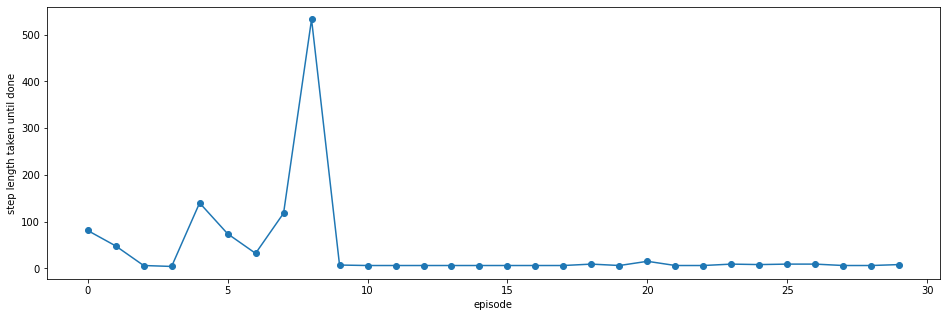

In [246]:
plt.figure(figsize=(16, 5))
plt.plot([len(re) for re in episodes_actions], marker='o')
plt.xlabel('episode')
plt.ylabel('step length taken until done')

In [247]:
# エピソード1
episodes_actions[0]

[<JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.GUU: 0>,
 <JankenHand.CHOKI: 1>,
 <Jank

In [248]:
# 最終エピソード
episodes_actions[-1]

[<JankenHand.GUU: 0>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.PAA: 2>,
 <JankenHand.CHOKI: 1>,
 <JankenHand.PAA: 2>,
 <JankenHand.GUU: 0>]